In [1]:
import ast
import csv
import glob
import matplotlib.pyplot as plt
import numpy as np
import re

plt.rcParams["figure.dpi"] = 300
plt.rcParams["font.family"] = "Times New Roman"

# Models
models = {'gpt-4-azure': 'GPT-4', 'gpt-4o': 'GPT-4o', 'llama': 'Llama-3.1-405B'}

def levenshtein_similarity(list1, list2):
    len1, len2 = len(list1), len(list2)
    
    # Create a 2D table to store the distances
    dp = [[0 for _ in range(len2 + 1)] for _ in range(len1 + 1)]
    
    # Initialize the base cases
    for i in range(len1 + 1):
        dp[i][0] = i
    for j in range(len2 + 1):
        dp[0][j] = j
    
    # Fill the DP table
    for i in range(1, len1 + 1):
        for j in range(1, len2 + 1):
            if list1[i - 1] == list2[j - 1]:
                dp[i][j] = dp[i - 1][j - 1]
            else:
                dp[i][j] = 1 + min(dp[i - 1][j],    # Deletion
                                   dp[i][j - 1],    # Insertion
                                   dp[i - 1][j - 1]) # Substitution
    
    # Levenshtein distance
    distance = dp[len1][len2]
    
    # Levenshtein similarity
    similarity = 1 - (distance / max(len1, len2))
    
    return similarity

def get_accuracy(filename):
    with open(filename, 'r') as f:
        lines = f.read()
        
    accuracies = re.findall(r'Accuracy: (.*?)\n', lines)
    return accuracies

def get_label_and_response(filename):
    with open(filename, 'r') as f:
        lines = f.read()
        
    labels = re.findall(r'"label": "(.*?)",', lines)
    responses = re.findall(r'"response": "(.*?)",', lines)
    assert len(labels) == len(responses) and len(labels)%2 == 0
    return labels, responses

def extract_levensthein_from_logs(model, path, possible_ops, regexp):
    results = {}
    for filename in glob.glob(path):
        if model in filename and "__exclude__" not in filename:
            
            print(filename)
            # Get all the labels and responses
            labels, responses = get_label_and_response(filename)  # IMPORTANT: first comes sythetic, then nat
            n = int(len(labels)/2)
            
            # Get natural and synthetic labels and responses
            labels_syn, responses_syn = labels[n:], responses[n:]
            labels_nat, responses_nat = labels[:n], responses[:n]
            
            # Compute the Levensthein between the two sets
            distances_syn, distances_nat = [], []
            for (l_syn, r_syn),(l_nat, r_nat) in zip(zip(labels_syn, responses_syn), zip(labels_nat, responses_nat)):

                try:
                    l_syn = ast.literal_eval(l_syn)
                    r_syn = ast.literal_eval(r_syn)
                    d_syn = levenshtein_similarity(l_syn, r_syn)
                except:
                    d_syn = 0.
                
                distances_syn.append(d_syn)
                
                try:
                    l_nat = ast.literal_eval(l_nat)
                    r_nat = ast.literal_eval(r_nat)
                    d_nat = levenshtein_similarity(l_nat, r_nat)
                except:
                    d_nat = 0.
                    
                distances_nat.append(d_nat)
            
            n_ops = re.findall(regexp, filename)[0]

            if n_ops not in results:
                results[n_ops] = {"syn": [], "nat": []}

            results[n_ops]["syn"].append(float(np.mean(distances_syn)))
            results[n_ops]["nat"].append(float(np.mean(distances_nat)))

    acc_syn = [results[str(n)]["syn"] for n in possible_ops if str(n) in results]
    acc_nat = [results[str(n)]["nat"] for n in possible_ops if str(n) in results]

    acc_syn_mean = [np.mean(a) if a else 0 for a in acc_syn]
    acc_nat_mean = [np.mean(a) if a else 0 for a in acc_nat]
    acc_syn_std = [np.std(a) if a else 0 for a in acc_syn]
    acc_nat_std = [np.std(a) if a else 0 for a in acc_nat]

    return possible_ops, acc_syn_mean, acc_syn_std, acc_nat_mean, acc_nat_std

def extract_results_from_logs(model, path, possible_ops, regexp):
    """Extract results from logs (.txt) files as per the logs/ folder"""
    results = {}
    for filename in glob.glob(path):
        if model in filename and "__exclude__" not in filename:
            a_nat, a_syn = get_accuracy(filename)  # IMPORTANT: first comes sythetic, then nat

            n_ops = re.findall(regexp, filename)[0]

            if n_ops not in results:
                results[n_ops] = {"syn": [], "nat": []}

            results[n_ops]["syn"].append(float(a_syn))
            results[n_ops]["nat"].append(float(a_nat))

    acc_syn = [results[str(n)]["syn"] for n in possible_ops if str(n) in results]
    acc_nat = [results[str(n)]["nat"] for n in possible_ops if str(n) in results]

    acc_syn_mean = [np.mean(a) if a else 0 for a in acc_syn]
    acc_nat_mean = [np.mean(a) if a else 0 for a in acc_nat]
    acc_syn_std = [np.std(a) if a else 0 for a in acc_syn]
    acc_nat_std = [np.std(a) if a else 0 for a in acc_nat]

    return possible_ops, acc_syn_mean, acc_syn_std, acc_nat_mean, acc_nat_std

# Extract results for straight line
def extract_results_from_csv(model, path, possible_ops, regexp):
    """Extrac results from .csv files as per the results/ folder"""

    results = {}
    for filename in glob.glob(path):
        if model in filename and "__exclude__" not in filename:
            
            print(filename)
            with open(filename, mode='r') as file:
                csv_reader = csv.reader(file)  # skip the first row

                next(csv_reader)
                for row in csv_reader:
                    if len(row) != 4:
                        continue 
                    
                    try:
                        n_ops = re.findall(regexp, row[3])[0]
                        
                        if n_ops not in results:
                            results[n_ops] = {"syn": [], "nat": []}
                        
                        results[n_ops]["syn"].append(float(row[1]))
                        results[n_ops]["nat"].append(float(row[0]))
                    
                    except:
                        pass
            
    acc_syn = [results[str(n)]["syn"] for n in possible_ops if str(n) in results]
    acc_nat = [results[str(n)]["nat"] for n in possible_ops if str(n) in results]

    acc_syn_mean = [np.mean(a) if a else 0 for a in acc_syn]
    acc_nat_mean = [np.mean(a) if a else 0 for a in acc_nat]
    acc_syn_std = [np.std(a) if a else 0 for a in acc_syn]
    acc_nat_std = [np.std(a) if a else 0 for a in acc_nat]

    return possible_ops, acc_syn_mean, acc_syn_std, acc_nat_mean, acc_nat_std

In [2]:
def plot(models:dict,
         path:str,
         n_ops:list,
         regexp:str,
         title="",
         ylabel="Accuracy",
         extract_function=extract_results_from_csv,
         ) -> None:
    # Straight line
    _, axes = plt.subplots(1, len(models), figsize=(15, 4), sharey=True)

    for i, model in enumerate(models):
        possible_ops, acc_syn_mean, acc_syn_std, acc_nat_mean, acc_nat_std = extract_function(model,
                                                                                             path,
                                                                                             n_ops,
                                                                                             regexp)
        
        # possible_ops, acc_syn_mean, acc_syn_std, acc_nat_mean, acc_nat_std = extract_results_from_logs(model,
        #                                                                                      "./logs/straight-line/*.txt",
        #                                                                                      [10, 20, 30, 40, 50],
        #                                                                                      r'n_ops-(.*?)_')

        axes[i].errorbar(possible_ops, acc_syn_mean, yerr=acc_syn_std, color='darkred', label='Synthetic', alpha=0.6, capsize=5, ecolor='darkred')
        axes[i].fill_between(possible_ops, 
                            [m - s for m, s in zip(acc_syn_mean, acc_syn_std)], 
                            [m + s for m, s in zip(acc_syn_mean, acc_syn_std)], 
                            color='red', alpha=0.2)

        axes[i].errorbar(possible_ops, acc_nat_mean, yerr=acc_nat_std, color='navy', label='Naturalistic', alpha=0.6, capsize=5, ecolor='navy')
        axes[i].fill_between(possible_ops, 
                            [m - s for m, s in zip(acc_nat_mean, acc_nat_std)], 
                            [m + s for m, s in zip(acc_nat_mean, acc_nat_std)], 
                            color='blue', alpha=0.2)
        axes[i].set_title((title if i==1 else ""), weight="bold")
        axes[i].set_xlabel(models[model], size=12)
        axes[i].set_ylabel(ylabel, size=12) if i == 0 else None
        axes[i].legend()
        axes[i].grid(alpha=0.5)

    plt.tight_layout()
    plt.show()

./results/straight-line/gpt-4-azure.csv
./results/straight-line/gpt-4o.csv
./results/straight-line/sambanova-llama.csv


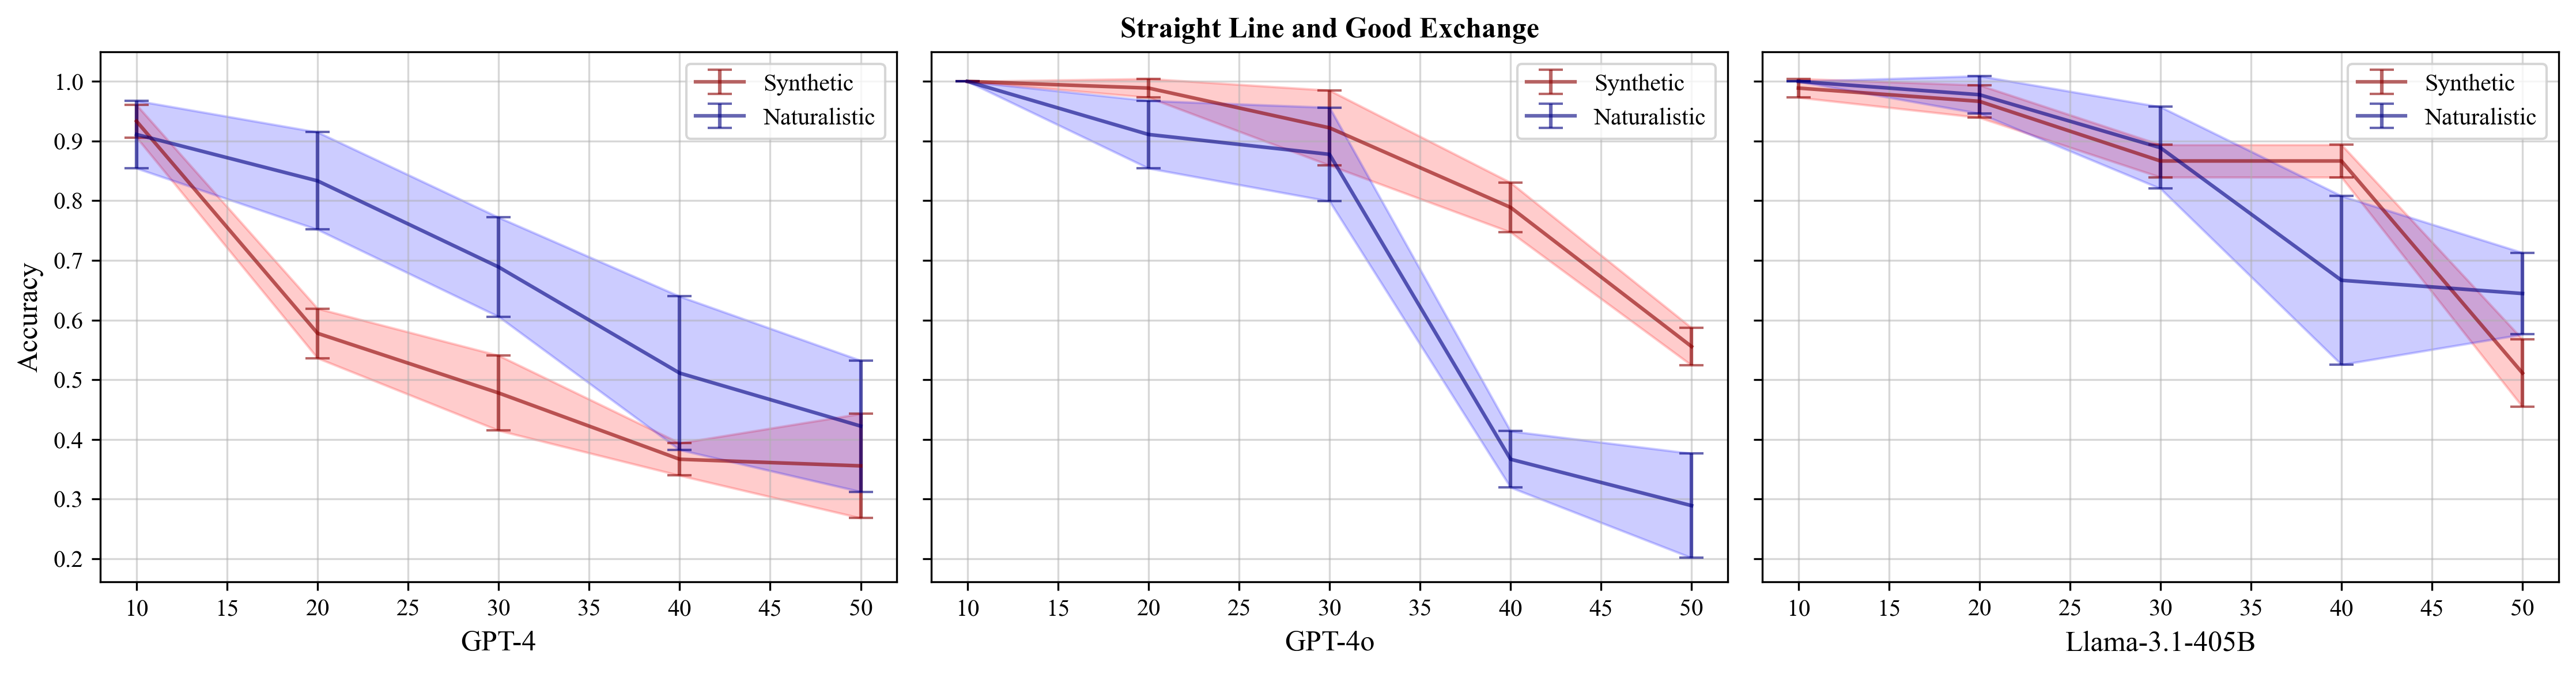

In [28]:
# Straight line
plot(models, 
     "./results/straight-line/*.csv", 
     [10, 20, 30, 40, 50], 
     r'n_ops-(.*?)_',
     "Straight Line and Good Exchange")

./results/critical-path/gpt-4-azure.csv
./results/critical-path/gpt-4o.csv
./results/critical-path/sambanova-llama.csv


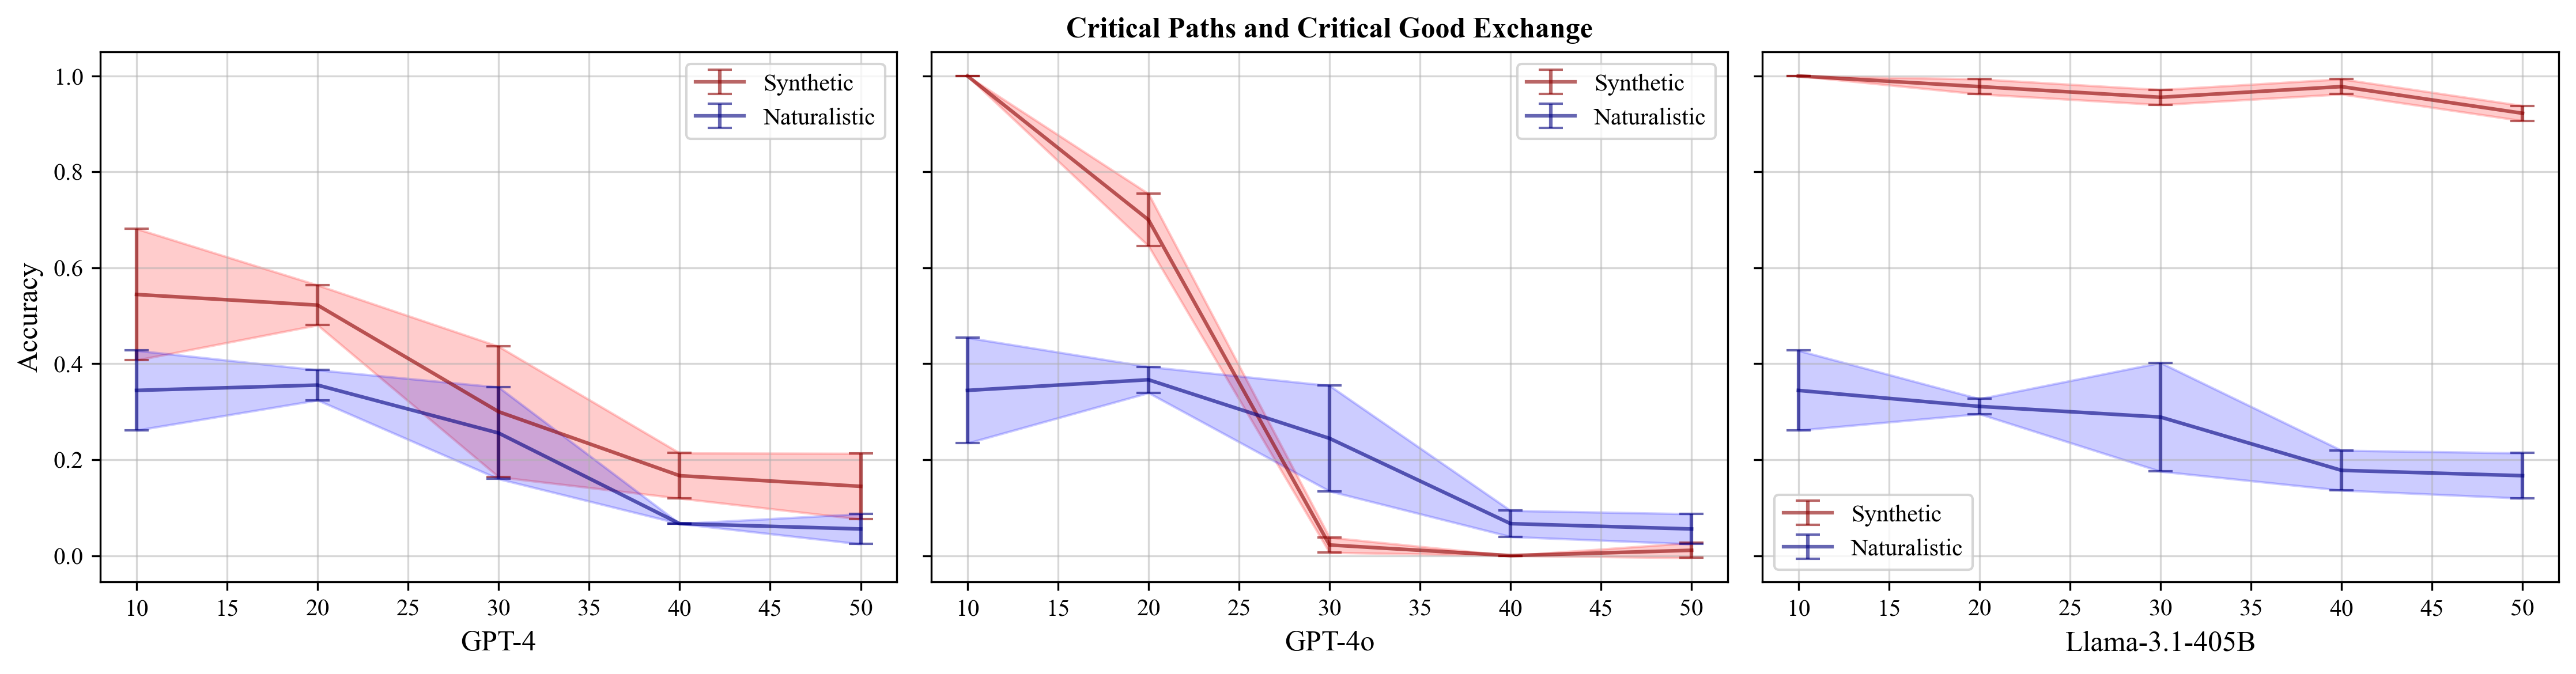

In [29]:
# # Critical path backup
# plot(models,
#     "./results/backup/critical-path-23-01-2025/*.csv",
#     [10, 20, 30, 40, 50],
#     r'n_ops-(.*?)_',
#     "Critical Paths and Critical Good Exchange (Backup)")

# Critical path
plot(models,
    "./results/critical-path/*.csv",
    [10, 20, 30, 40, 50],
    r'n_ops-(.*?)_',
    "Critical Paths and Critical Good Exchange")

./logs/parallel-paths/n_ops-10_n_vars-3_n_instances-2_batch-1.json-gpt-4-azure-01M-23D-12h-53m44s.txt
./logs/parallel-paths/n_ops-50_n_vars-3_n_instances-2_batch-1.json-gpt-4-azure-01M-24D-15h-41m18s.txt
./logs/parallel-paths/n_ops-30_n_vars-3_n_instances-2_batch-1.json-gpt-4-azure-01M-20D-21h-42m01s.txt
./logs/parallel-paths/n_ops-40_n_vars-3_n_instances-2_batch-2.json-gpt-4-azure-01M-23D-15h-38m33s.txt
./logs/parallel-paths/n_ops-30_n_vars-3_n_instances-2_batch-1.json-gpt-4-azure-01M-23D-14h-12m57s.txt
./logs/parallel-paths/n_ops-20_n_vars-3_n_instances-2_batch-3.json-gpt-4-azure-01M-24D-13h-53m40s.txt
./logs/parallel-paths/n_ops-10_n_vars-3_n_instances-2_batch-2.json-gpt-4-azure-01M-23D-13h-03m41s.txt
./logs/parallel-paths/n_ops-30_n_vars-3_n_instances-2_batch-3.json-gpt-4-azure-01M-24D-14h-48m42s.txt
./logs/parallel-paths/n_ops-20_n_vars-3_n_instances-2_batch-1.json-gpt-4-azure-01M-21D-20h-43m15s.txt
./logs/parallel-paths/n_ops-30_n_vars-3_n_instances-2_batch-2.json-gpt-4-azure-01M

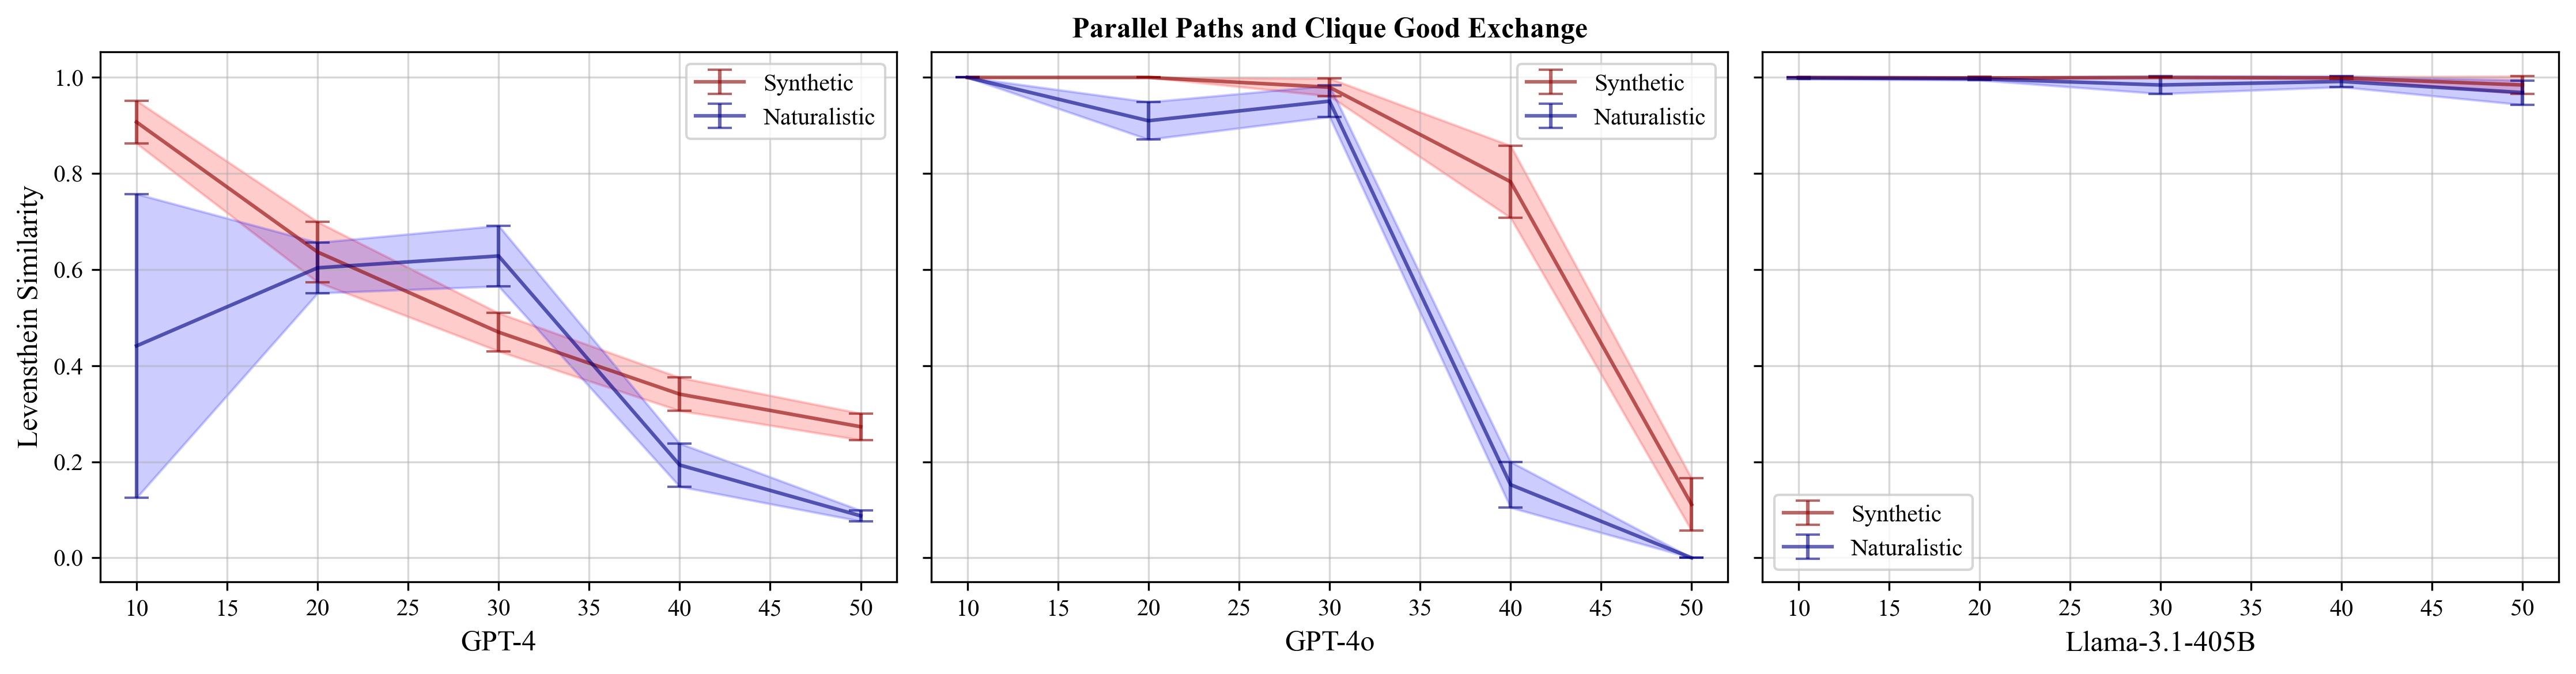

In [30]:
# Parallel path
plot(models,
    "./logs/parallel-paths/*.txt",
    [10, 20, 30, 40, 50],
    r'n_ops-(.*?)_',
    "Parallel Paths and Clique Good Exchange",
    "Levensthein Similarity",
    extract_function=extract_levensthein_from_logs)

./results/nested-loop/gpt-4-azure.csv
./results/nested-loop/gpt-4o.csv
./results/nested-loop/sambanova-llama.csv


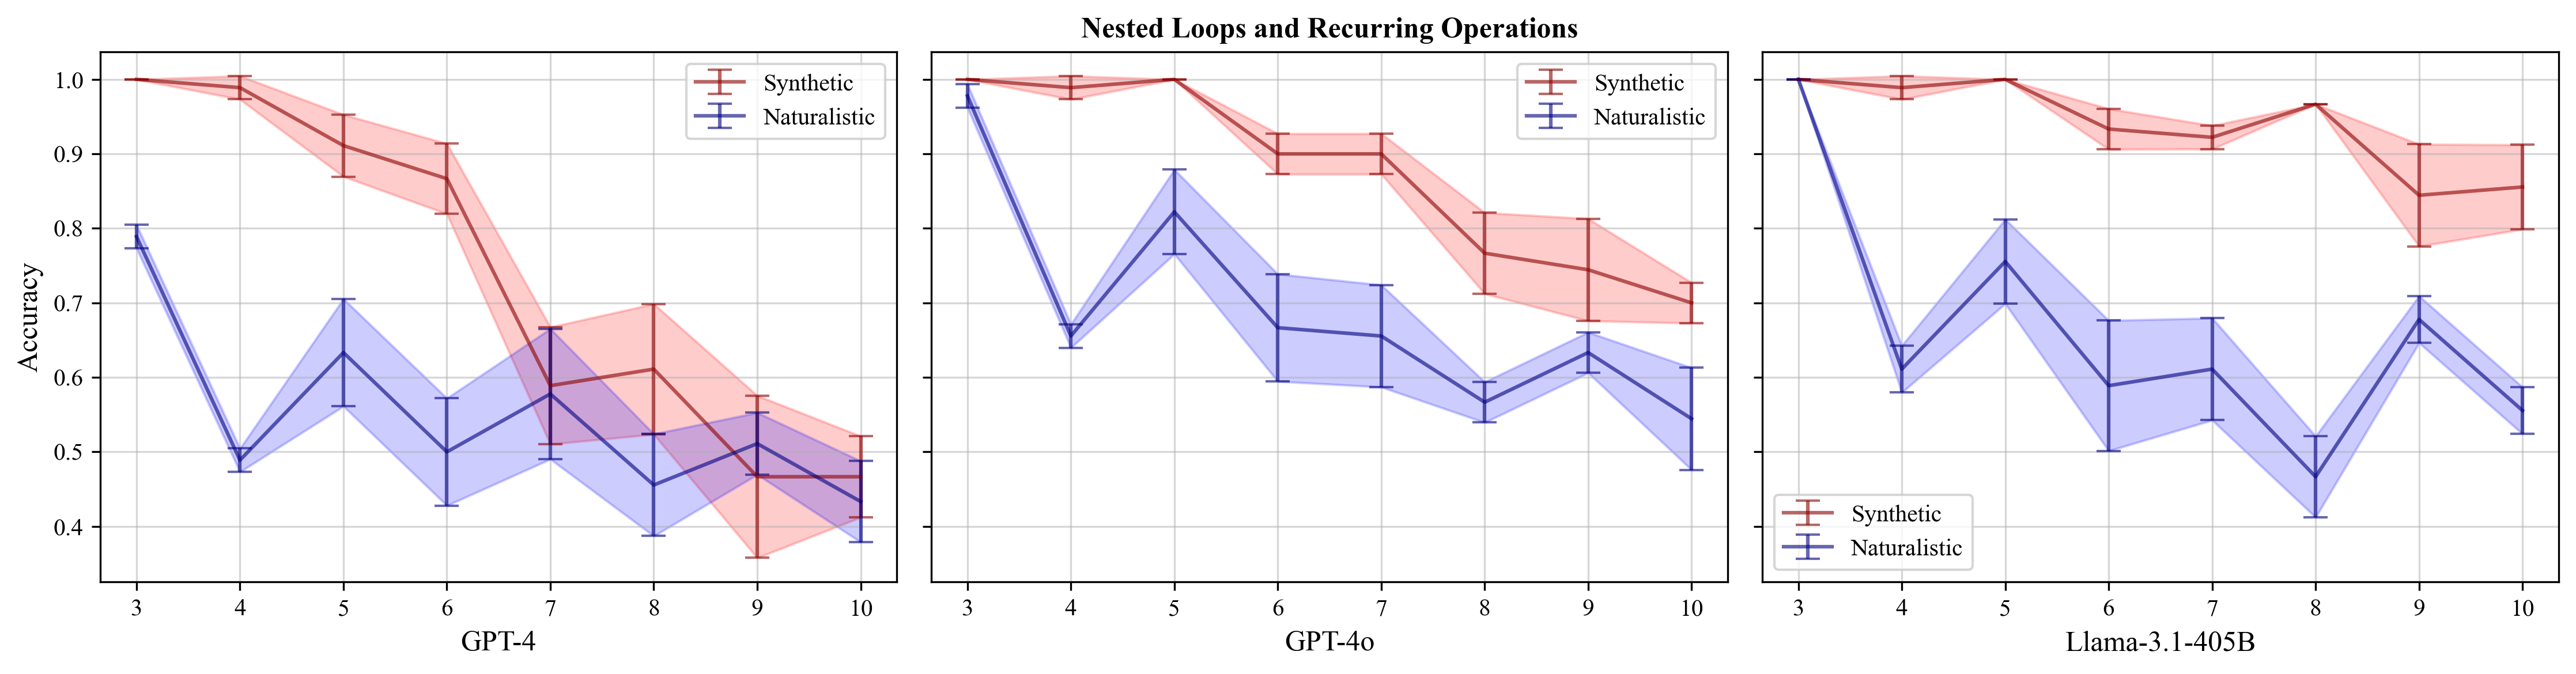

In [31]:
# Nested loops
plot(models,
    "./results/nested-loop/*.csv",
    [3, 4, 5, 6, 7, 8, 9, 10],
    r'n_loops-(.*?)_',
    "Nested Loops and Recurring Operations")


./results/kim-schuster/gpt-4-azure.csv
./results/kim-schuster/gpt-4o.csv
./results/kim-schuster/sambanova-llama.csv


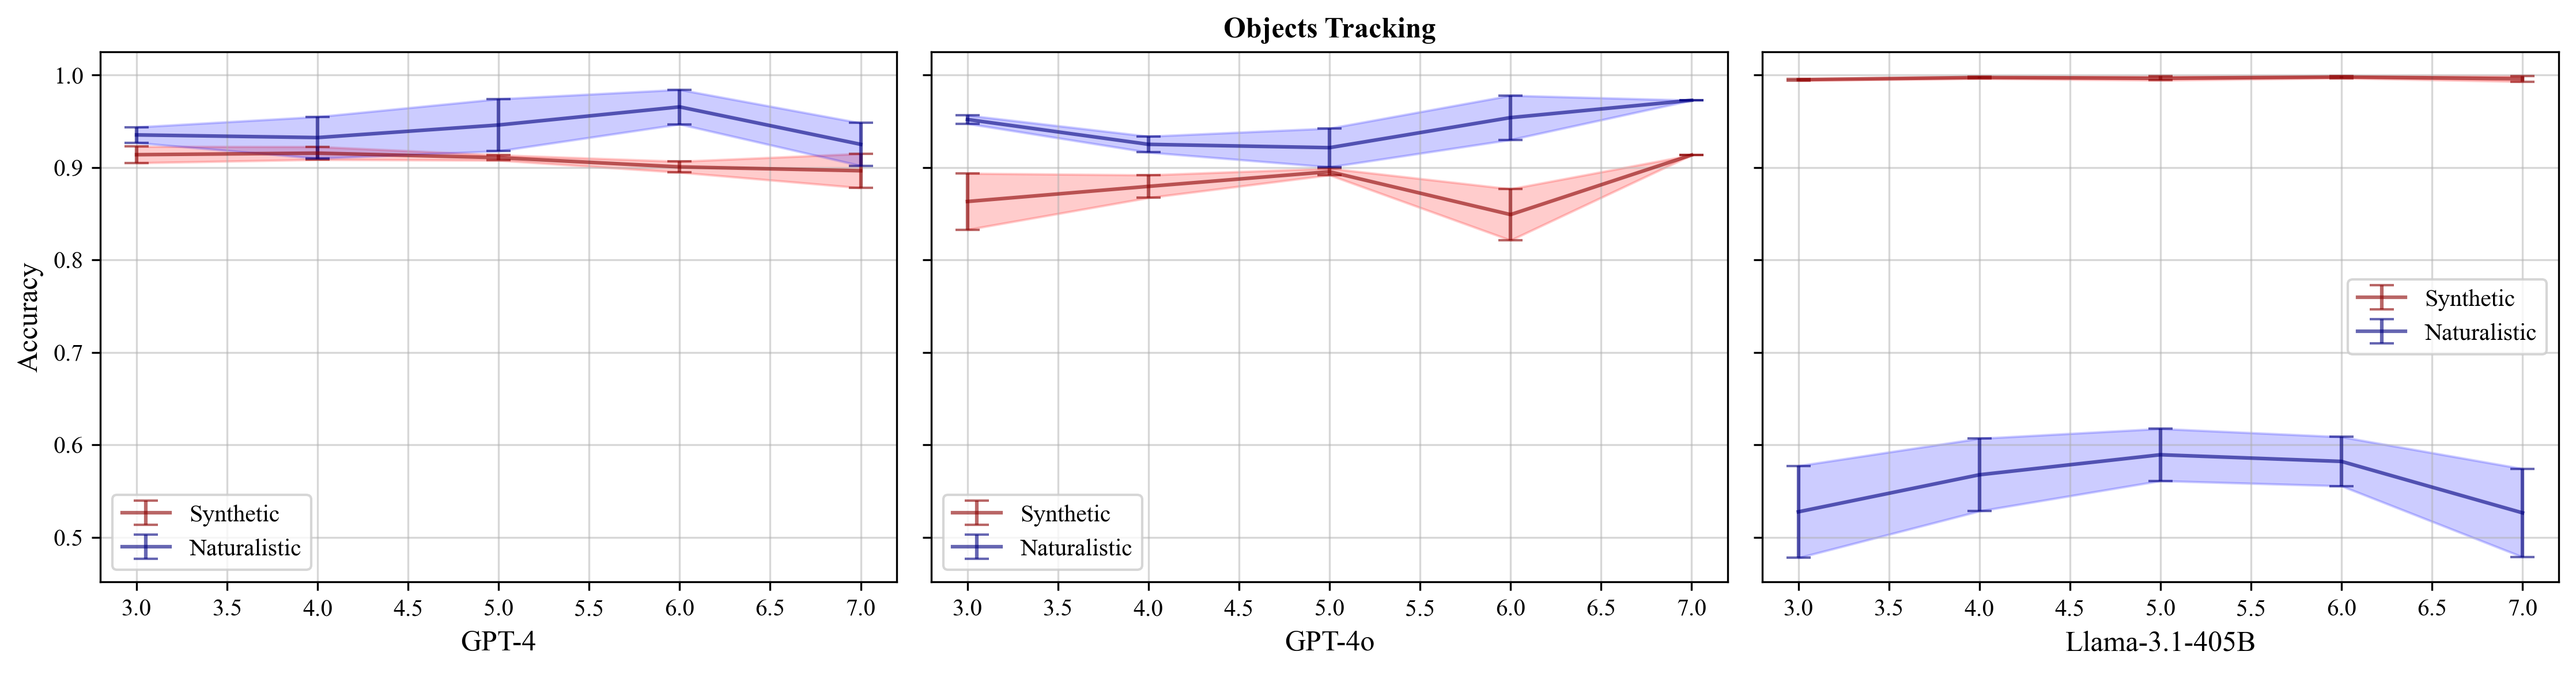

In [4]:
# Kim-Schuster
plot(models,
    "./results/kim-schuster/*.csv",
    [3, 4, 5, 6, 7],
    r'max_items_per_box-(.*?)-',
    "Objects Tracking")

./results/sorting/gpt-4-azure.csv
./results/sorting/gpt-4o.csv
./results/sorting/sambanova-llama.csv


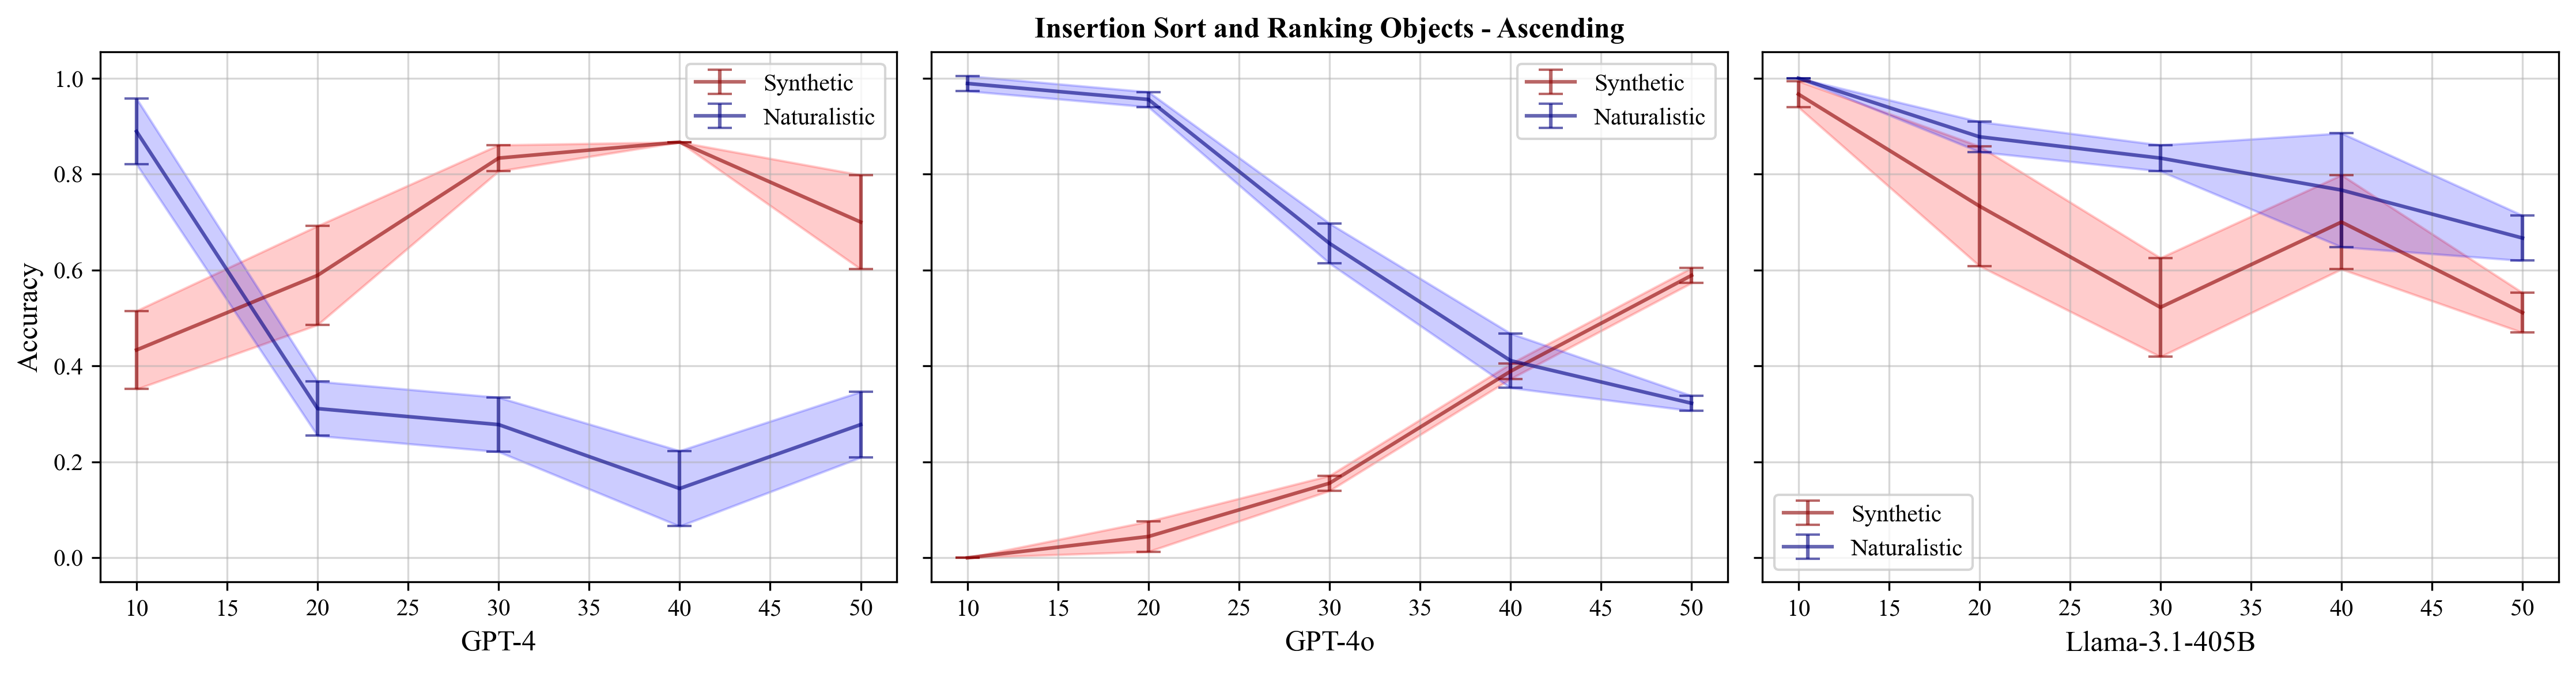

./results/sorting/gpt-4-azure.csv
./results/sorting/gpt-4o.csv
./results/sorting/sambanova-llama.csv


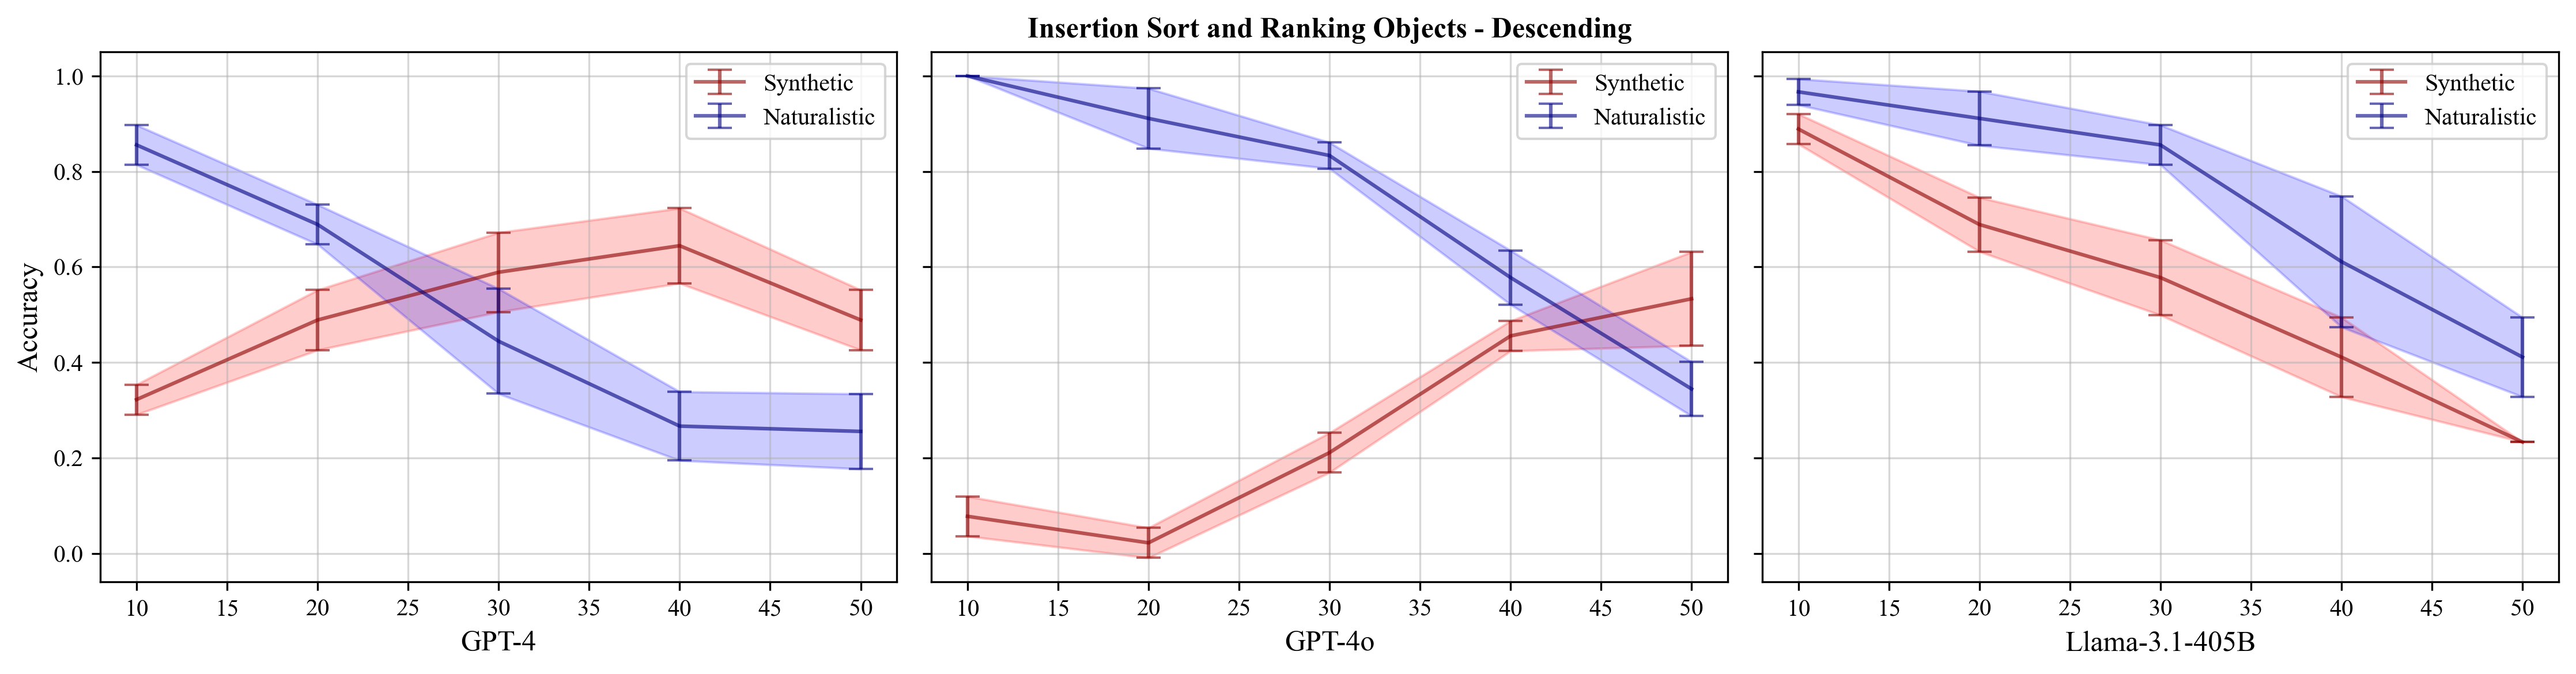

In [33]:
# Insertion Sort larger granularity
plot(models,
    "./results/sorting/*.csv",
    [10, 20, 30, 40, 50],
    r'n_vars-(.*?)_ascending-True',
    "Insertion Sort and Ranking Objects - Ascending")

plot(models,
    "./results/sorting/*.csv",
    [10, 20, 30, 40, 50],
    r'n_vars-(.*?)_ascending-False',
    "Insertion Sort and Ranking Objects - Descending")

./results/backup/bubblesort-23-01-2025/gpt-4-azure.csv
./results/backup/bubblesort-23-01-2025/gpt-4o.csv
./results/backup/bubblesort-23-01-2025/sambanova-llama.csv


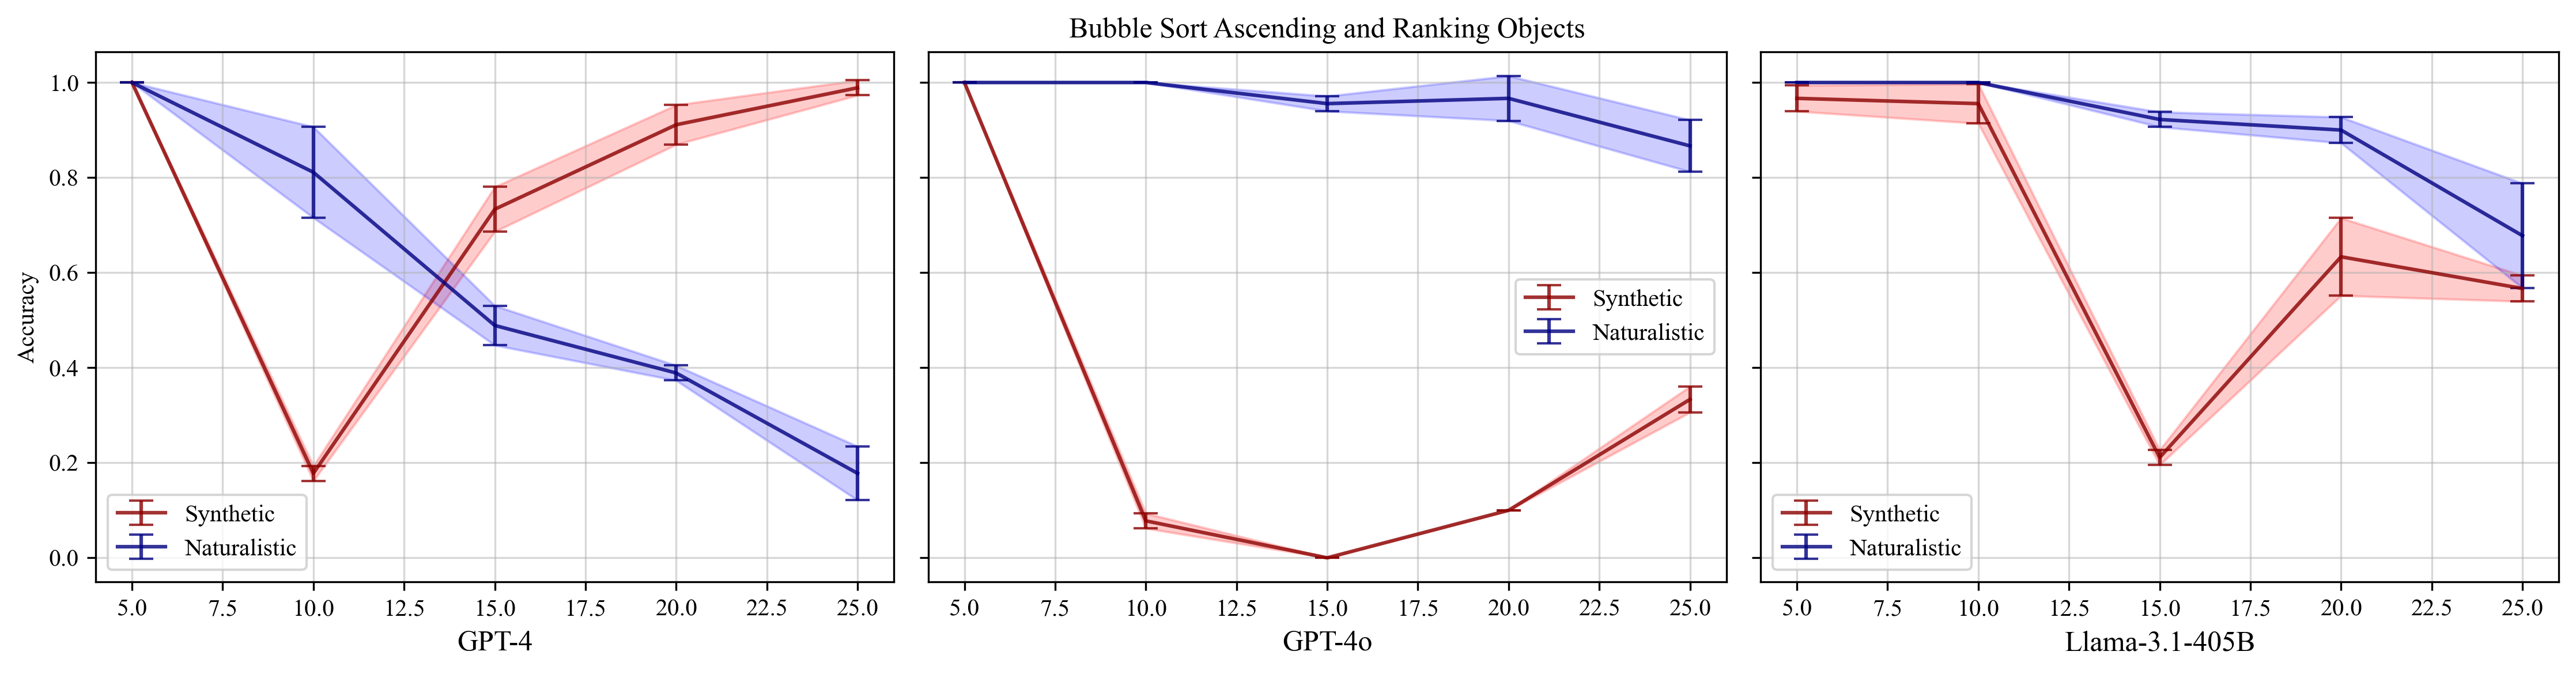

./results/backup/bubblesort-23-01-2025/gpt-4-azure.csv
./results/backup/bubblesort-23-01-2025/gpt-4o.csv
./results/backup/bubblesort-23-01-2025/sambanova-llama.csv


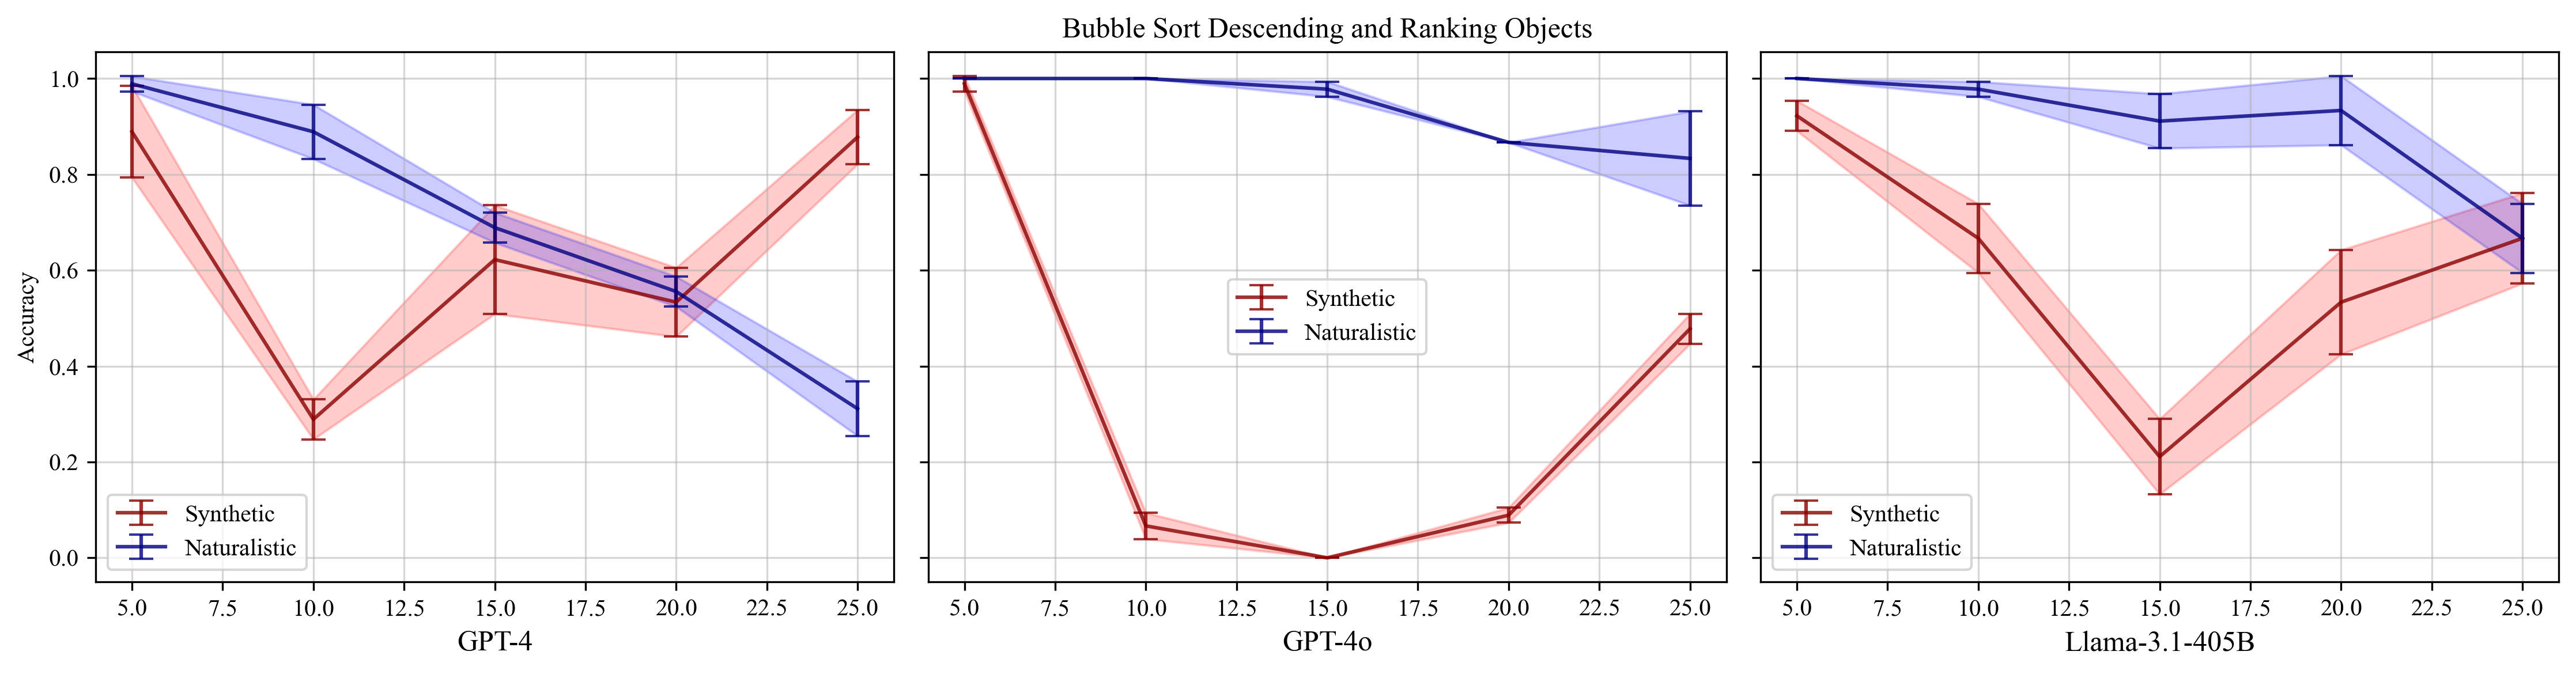

In [20]:
# Sorting Bubble Sort
plot(models,
    "./results/backup/bubblesort-23-01-2025/*.csv",
    [5, 10, 15, 20, 25],
    r'n_vars-(.*?)_ascending-True',
    "Bubble Sort Ascending and Ranking Objects")

plot(models,
    "./results/backup/bubblesort-23-01-2025/*.csv",
    [5, 10, 15, 20, 25],
    r'n_vars-(.*?)_ascending-False',
    "Bubble Sort Descending and Ranking Objects")

./results/backup/insertionsort-23-01-2025/gpt-4-azure.csv
./results/backup/insertionsort-23-01-2025/gpt-4o.csv
./results/backup/insertionsort-23-01-2025/sambanova-llama.csv


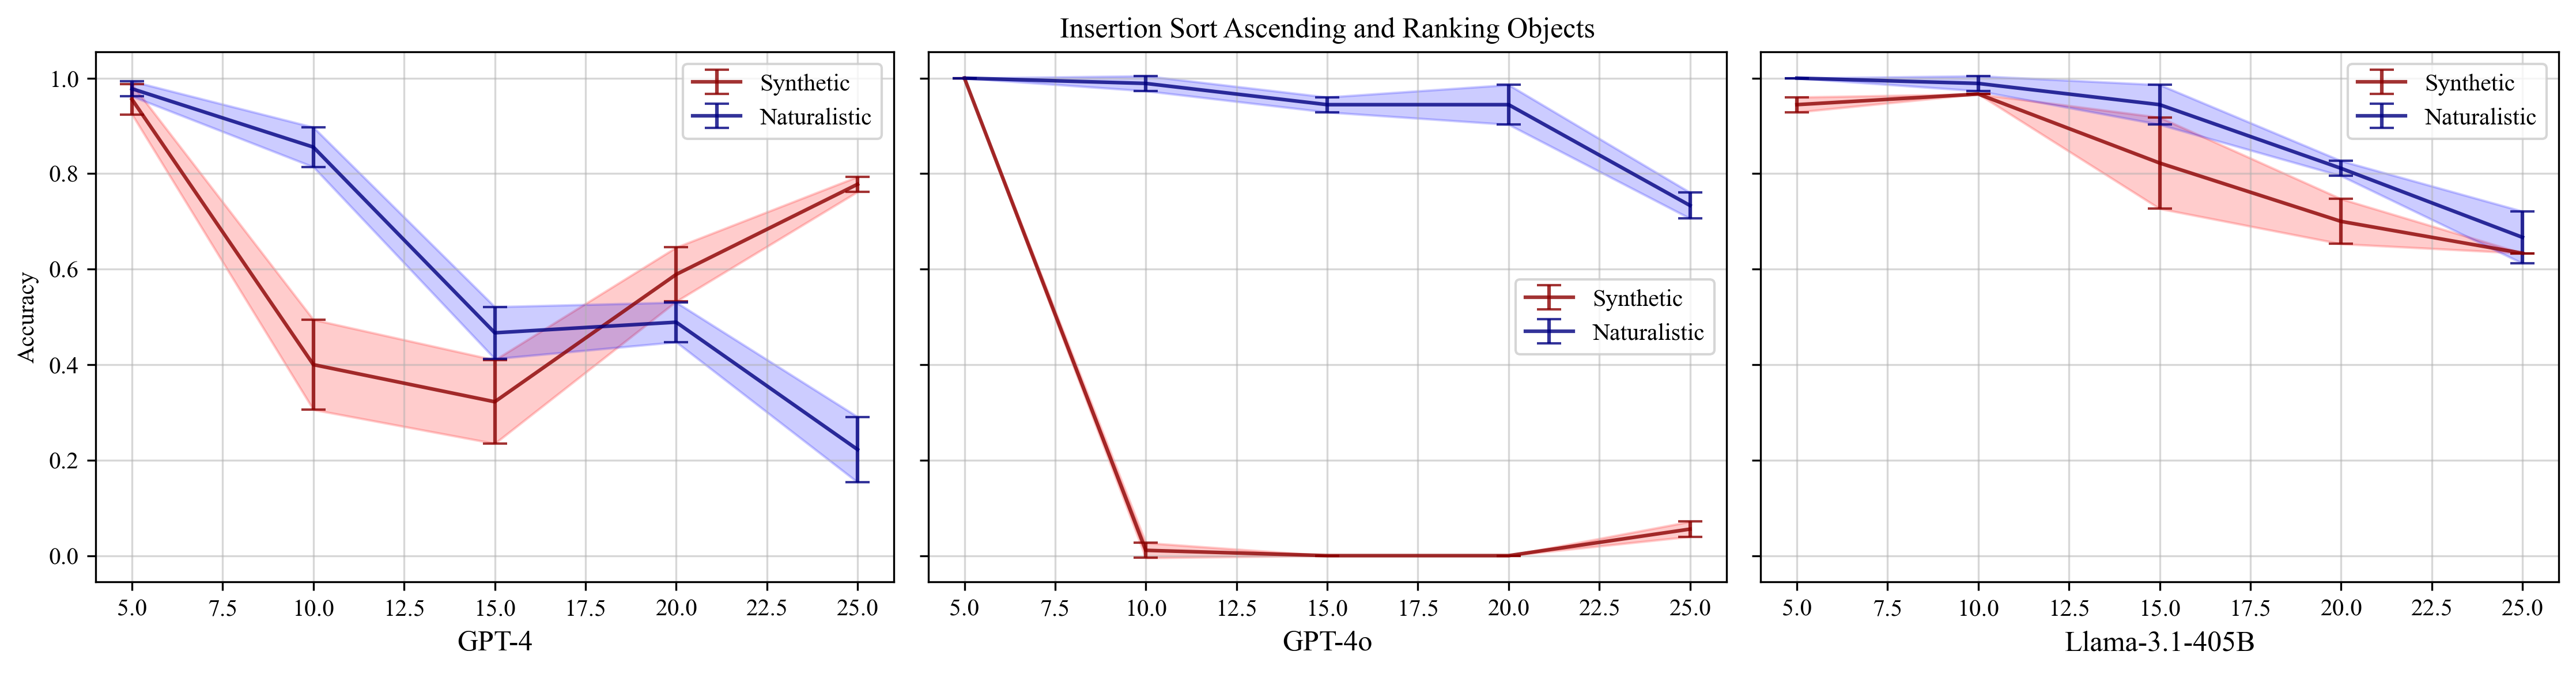

./results/backup/insertionsort-23-01-2025/gpt-4-azure.csv
./results/backup/insertionsort-23-01-2025/gpt-4o.csv
./results/backup/insertionsort-23-01-2025/sambanova-llama.csv


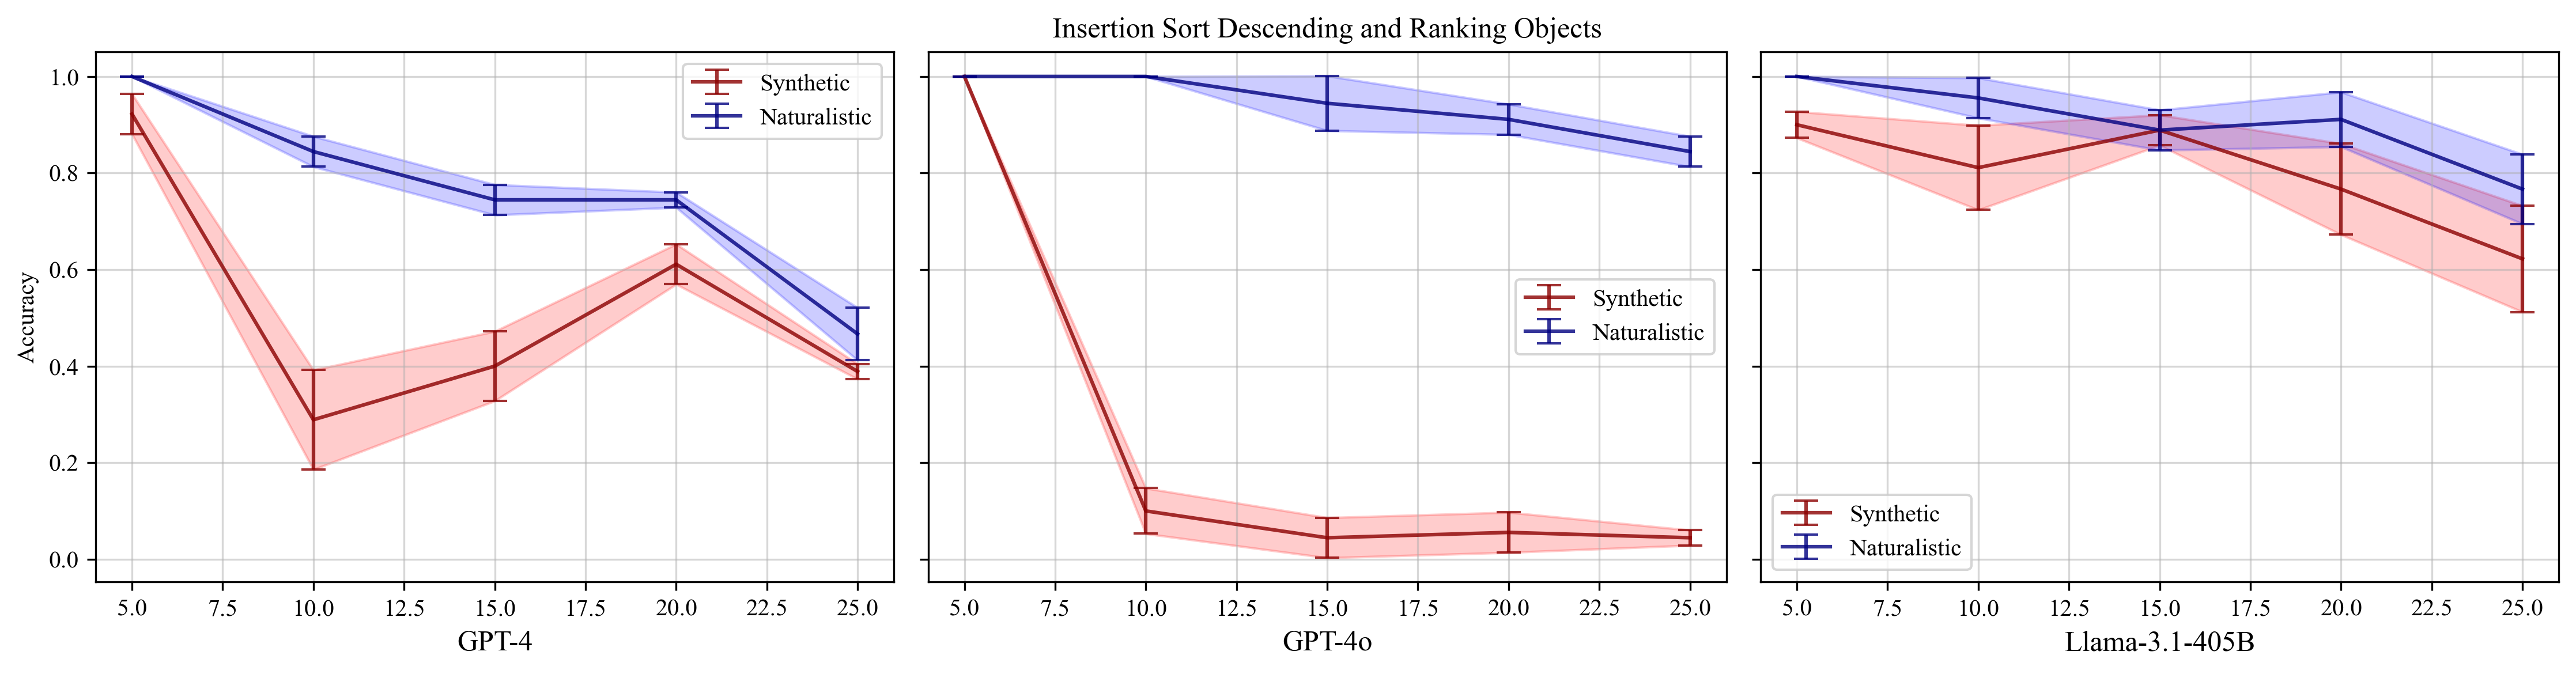

In [21]:
# Sorting Insertion Sort
plot(models,
    "./results/backup/insertionsort-23-01-2025/*.csv",
    [5, 10, 15, 20, 25],
    r'n_vars-(.*?)_ascending-True',
    "Insertion Sort Ascending and Ranking Objects")

plot(models,
    "./results/backup/insertionsort-23-01-2025/*.csv",
    [5, 10, 15, 20, 25],
    r'n_vars-(.*?)_ascending-False',
    "Insertion Sort Descending and Ranking Objects")